# Answering Business Questions using SQL

This project is intended as practice material for using SQL skills to answer business questions. 

The project utilizes SQLite3 database file "Chinook.db". 

The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store. The information is about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases.

Here's a schema diagram for the Chinook database:

![chinook_schema.png](chinook_schema.png)

## Import libraries, intialize Magic Line

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

pd.set_option('display.max_colwidth', -1)

# # to display values of all variables and not just the last one in a cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## Define helper functions for SQL queries

    - run_query() function accepts a query as an input and fetches the results as a dataframe
    - run_command() function accepts a SQL command and executes it directly on database ie. autocommit
    - show_tables() function accepts no parameter and shows all the tables and view in Chinook database

In [2]:
def run_query(sql_query):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(sql_query, conn)
    
def run_command(sql_command):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(sql_command)
        
def show_tables():
    show_query = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    return run_query(show_query)

In [3]:
# run_query("SELECT * FROM pragma_table_info('album')")

run_query("PRAGMA table_info('album')")

,cid,name,type,notnull,dflt_value,pk
0,0,album_id,INTEGER,1,None,1
1,1,title,NVARCHAR(160),1,None,0
2,2,artist_id,INTEGER,1,None,0


## Display all schema tables

In [4]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Select albums that should be purchased based on their genres

In [5]:
q = "SELECT * FROM invoice_line LIMIT 5"
run_query(q)

,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,1,1158,0.99,1
1,2,1,1159,0.99,1
2,3,1,1160,0.99,1
3,4,1,1161,0.99,1
4,5,1,1162,0.99,1


In [6]:
q = "SELECT * FROM invoice LIMIT 2"
run_query(q)

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total,tax,subtotal
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,0,15.84
1,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.90,0,9.90


In [7]:
q = "SELECT * FROM customer LIMIT 2"
run_query(q)

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
1,2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5


In [8]:
genre_wise_tracks_sold = """

WITH 
    USA_only AS
    (
        SELECT IL.track_id, IL.invoice_line_id
        FROM invoice_line IL
        INNER JOIN invoice I ON IL.invoice_id = I.invoice_id
        INNER JOIN customer C ON I.customer_id = C.customer_id
        WHERE C.country = "USA"
    ),   
    Genre_track AS
    (
        SELECT
            G.name Genre,
            COUNT(U.invoice_line_id) AS tracks_sold,
            (CAST(COUNT(U.invoice_line_id) AS float) / (SELECT COUNT(*) FROM USA_only))*100 AS "tracks_sold_in_%"
        FROM USA_only U
        INNER JOIN track T ON U.track_id = T.track_id
        INNER JOIN genre G ON T.genre_id = G.genre_id
        GROUP BY 1 
        ORDER BY 2 DESC
        )
        
SELECT * FROM Genre_track LIMIT 10;

"""
genre_df = run_query(genre_wise_tracks_sold)
genre_df.set_index("Genre", inplace=True, drop=True)

## Display Genres of the Top Selling Tracks/albums

In [9]:
genre_df

,tracks_sold,tracks_sold_in_%
Genre,,
Rock,561,53.377735
Alternative & Punk,130,12.369172
Metal,124,11.798287
R&B/Soul,53,5.042816
Blues,36,3.425309
Alternative,35,3.330162
Pop,22,2.093245
Latin,22,2.093245
Hip Hop/Rap,20,1.902950


## Plot results of Top Selling Tracks Genre wise

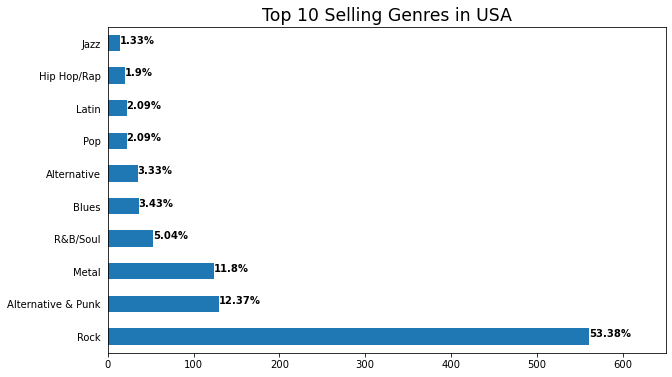

In [10]:
ax = genre_df.plot.barh(y="tracks_sold", legend=False, 
                        rot=0, figsize=(10,6), fontsize=10, width=0.5, xlim=(0,650) ) 
ax.set_ylabel("")
ax.set_title(label="Top 10 Selling Genres in USA", fontsize="xx-large")

for index, label in enumerate(list(genre_df.index)):
    track_count = genre_df.loc[label, "tracks_sold"]
    track_perc = genre_df.loc[label, "tracks_sold_in_%"].round(2).astype(str) + "%"
    ax.annotate(str(track_perc), (track_count, index), fontweight="demibold")
    ax.tick_params(bottom=True, top=False, left=False, right=False)

The most sold out album genre is Rock. However, since none of the four genres from the new artists is Rock, based on the results above, following three genres would be good candidates for purchase by Chinook:
    
| Artist Name | Genre |
| ----------- | ----- | 
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

<h3>Analyzing Employee Sales Performance</h3>

In [11]:
q = """SELECT 
            iv.customer_id,
            SUM(iv.total) AS purchase 
       FROM invoice as iv 
       GROUP BY customer_id
       HAVING purchase > 90.00
       LIMIT 4"""

run_query(q)

,customer_id,purchase
0,1,108.90
1,3,99.99
2,5,144.54
3,6,128.70


In [12]:
q = """select employee_id, (first_name||" "||last_name) AS Employee, title, hire_date from employee"""
run_query(q)

,employee_id,Employee,title,hire_date
0,1,Andrew Adams,General Manager,2016-08-14 00:00:00
1,2,Nancy Edwards,Sales Manager,2016-05-01 00:00:00
2,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00
3,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00
4,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00
5,6,Michael Mitchell,IT Manager,2016-10-17 00:00:00
6,7,Robert King,IT Staff,2017-01-02 00:00:00
7,8,Laura Callahan,IT Staff,2017-03-04 00:00:00


In [13]:
q = "select * from employee limit 1"
run_query(q)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,None,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com


In [14]:
q = "select distinct(support_rep_id) from customer"
run_query(q)

,support_rep_id
0,3
1,4
2,5


In [15]:
q = "select * from customer limit 1"
run_query(q)

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3


In [16]:
q = "select * from invoice limit 1"
run_query(q)

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total,tax,subtotal
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,0,15.84


In [17]:
sales_per_emp = """
WITH 
    sales_cust AS
    (
        SELECT
            SUM(I.Total) total_sales,
            C.customer_id customer_id,
            C.support_rep_id support_rep_id
        FROM invoice I
        INNER JOIN customer C ON I.customer_id = c.customer_id
        GROUP BY 2,3
    )
SELECT
    E.first_name||" "||E.last_name Employee,
    SUM(SC.total_sales) Total_Sales,
    E.title Job_Title,
    E.hire_date Hire_Date
FROM employee E
INNER JOIN sales_cust SC ON SC.support_rep_id = E.employee_id
GROUP BY 1
ORDER BY 2 DESC
"""

employee_sales = run_query(sales_per_emp)
employee_sales.set_index("Employee", inplace=True, drop=True)
employee_sales

,Total_Sales,Job_Title,Hire_Date
Employee,,,
Jane Peacock,1731.51,Sales Support Agent,2017-04-01 00:00:00
Margaret Park,1584.00,Sales Support Agent,2017-05-03 00:00:00
Steve Johnson,1393.92,Sales Support Agent,2017-10-17 00:00:00


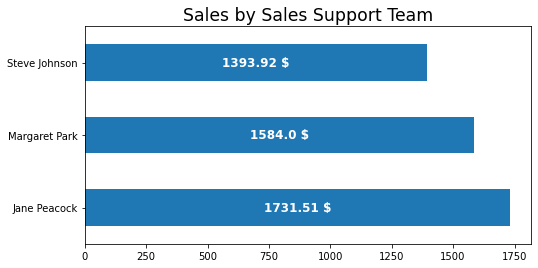

In [18]:
ax = employee_sales.plot(kind="barh", y="Total_Sales", legend=False, rot=0, figsize=(8,4), width=0.5)
ax.set_ylabel("")
ax.set_title("Sales by Sales Support Team", fontsize="xx-large")

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(round(width,2))+" $", xy=(left+width/2, bottom+height/2), 
                ha='center', va='center', fontsize=12, color="white", fontweight="demibold")   
plt.show()

<b>Conclusion:</b>
<i>Although the Total Sales by the 3 Sales support employees vary; the variation can be attributed to the difference in employment duration of these employees.</i>

<h3>Analyzing Sales by Country</h3>

    - Countries with only one customer have been clubbed together as "Others"

In [19]:
q = """
WITH
    /* This query selects the Total - Sales,Invoices & Customers for the countries having more than one customer */
    country_sales AS
    (    
        SELECT
            C.country Country,
            COUNT( DISTINCT (I.customer_id)) Total_Customers,
            SUM( I.total) Total_Sales,
            COUNT( DISTINCT (I.invoice_id)) Total_Invoices
        FROM invoice I
        INNER JOIN customer C ON I.customer_id = C.customer_id
        GROUP BY 1
        HAVING COUNT(DISTINCT(I.customer_ID)) > 1
    ),
    
    /* This query selects the Total - Sales,Invoices & Customers and groups them together for the countries 
       having only one customer */
    others_sales AS
    (
        SELECT 
            "Others" Country,
            COUNT(DISTINCT(I.customer_ID)) Total_Customers,
            SUM(I.total) Total_Sales,
            COUNT( DISTINCT (I.invoice_id)) Total_Invoices
        FROM invoice I
        INNER JOIN customer C ON I.customer_id = c.customer_id
        WHERE c.country NOT IN 
            (
                SELECT Country
                FROM country_sales
            )
    )
    
SELECT
    Country,
    Total_Customers,
    Total_Sales,
    ROUND("Avg_Sales/Customer", 3) "Avg_Sales/Customer",
    ROUND(Avg_Order_Value, 3) "Avg_Order_Price/Invoice"
FROM
(
    SELECT
        *,
        CASE
            WHEN Country = "Others" THEN 1
            ELSE 0
        END AS sort,
        (Total_Sales/ Total_Customers) AS "Avg_Sales/Customer",
        (Total_Sales/ Total_Invoices) AS "Avg_Order_Value"
    FROM 
    (SELECT * FROM country_sales
    UNION
    SELECT * FROM others_sales
    ORDER BY 3 DESC)
    ORDER BY sort
)
"""
sales_by_country = run_query(q)
sales_by_country.set_index("Country", inplace=True, drop=True)

sales_by_country.to_csv("sales_by_country.csv")

sales_by_country

,Total_Customers,Total_Sales,Avg_Sales/Customer,Avg_Order_Price/Invoice
Country,,,,
USA,13,1040.49,80.038,7.943
Canada,8,535.59,66.949,7.047
Brazil,5,427.68,85.536,7.011
France,5,389.07,77.814,7.781
Germany,4,334.62,83.655,8.161
Czech Republic,2,273.24,136.620,9.108
United Kingdom,3,245.52,81.840,8.769
Portugal,2,185.13,92.565,6.384
India,2,183.15,91.575,8.721


<b>Conclusion: </b><i>The "Others" in country represent countries which have only one customer. Although as a whole these do show high Sales, next to USA alone, they have low Avg Sales Per Customer and negative deviation from Mean of Order Prices overall.

The good candidates for business expansion/ improvment are:</i>
    - Czech Republic
    - United Kingdom
    - India
    
<i>Improved business strategies may be required for the following countries:</i>
    - Portugal
    - Brazil
    - Canada

<h3>Albums vs Individual Tracks</h3>

    - Albums with less than 2 tracks have been filtered out.

In [20]:
q = """
WITH
    -- This query selects the albums having more than 2 tracks
    album_track AS
    (
        SELECT
            T.album_id album_id,
            A.title album_name,
            COUNT(T.track_id) tracks
        FROM track T
        INNER JOIN album A ON T.album_id = A.album_id
        GROUP BY album_name
        HAVING tracks > 2
    ),
    invoice_track AS
    (
        SELECT
            IL.invoice_id invoice,
            T.album_id album_id,
            A.title album_name,
            COUNT(T.track_id) tracks
        FROM invoice_line IL
        INNER JOIN track T ON IL.track_id = T.track_id
        INNER JOIN album A ON T.album_id = A.album_id
        GROUP BY 1, 2
    )

SELECT Invoices AS Number_of_Invoices, Full_Album_Purchase, Percentage_of_Invoices FROM 
(
    /* This query select the invoices which do not have all the tracks purchased from an album, 
       rather tracks have been individually selected */
    SELECT 
        COUNT(DISTINCT(invoice)) Invoices,
        "No" AS Full_Album_Purchase,
        CAST(COUNT(DISTINCT(invoice)) AS FLOAT) / (SELECT COUNT(DISTINCT(invoice)) FROM invoice_track) * 100
        AS Percentage_of_Invoices
    FROM
    (
        SELECT * FROM invoice_track
        EXCEPT
        SELECT IT.* FROM invoice_track IT
        INNER JOIN album_track AT ON IT.album_name||IT.tracks = AT.album_name||AT.tracks
    )
    UNION
    -- This query select the invoices which have all the tracks from an album
    SELECT
        COUNT(DISTINCT(invoice)) Invoices,
        "Yes",
        CAST(COUNT(DISTINCT(invoice)) AS FLOAT) / (SELECT COUNT(DISTINCT(invoice)) FROM invoice_track) * 100
        AS Percentage_of_Invoices
    FROM
    (
        SELECT IT.* FROM invoice_track IT
        INNER JOIN album_track AT ON IT.album_name||IT.tracks = AT.album_name||AT.tracks
    )
)
"""
run_query(q)

,Number_of_Invoices,Full_Album_Purchase,Percentage_of_Invoices
0,111,Yes,18.078176
1,503,No,81.921824


<b>Conclusion: </b><i>Out of all the sales made at Chinook, 18% are full album purchases.

Since 18% customers prefer to buy full albums, it might not be in best interest of Chinook store to only purchase invidual tracks from record labels.

<h3>Artist used in the most playlists</h3>

    - Playlist table had duplicate records, with multiple playlist_id's for the same playlist.
    - Number of tracks was still counted for each playlist including duplicate ones, alongwith a self join query to test if           there are variations in the tracks associated with duplicate playlists.
    - Few playlists were empty i.e. have 0 tracks assigned.
    - For the duplicate playlists, playlist having higher value for "playlist_id" were selected, so as to avoid duplicate   tracks count as well.

In [21]:
q = """
SELECT
    name,
    COUNT(playlist_id) Playlist_Count
FROM playlist
GROUP BY name
HAVING Playlist_Count > 1 
ORDER BY 1 ASC
"""
run_query(q)

,name,Playlist_Count
0,Audiobooks,2
1,Movies,2
2,Music,2
3,TV Shows,2


In [22]:
q = """
SELECT
    P.name Playlist,
    PT1.playlist_id,
    COUNT(PT1.track_id) Number_of_Tracks
FROM
    playlist_track PT1,
    playlist_track PT2
LEFT JOIN playlist P ON P.playlist_id = PT1.playlist_id
WHERE PT1.track_id = PT2.track_id AND PT1.playlist_id = PT2.playlist_id
GROUP BY 1,2
ORDER BY 3 DESC, 1 ASC
"""
run_query(q)

,Playlist,playlist_id,Number_of_Tracks
0,Music,1,3290
1,Music,8,3290
2,90’s Music,5,1477
3,TV Shows,3,213
4,TV Shows,10,213
5,Classical,12,75
6,Brazilian Music,11,39
7,Heavy Metal Classic,17,26
8,Classical 101 - Deep Cuts,13,25
9,Classical 101 - Next Steps,14,25


In [23]:
q = """
WITH
    unique_playlist AS
    (
        SELECT * FROM playlist
        WHERE playlist_id IN 
            (
                SELECT MAX(playlist_id)
                FROM Playlist
                GROUP BY name
            )
    )
    
SELECT UP.name, UP.playlist_id, COUNT(PT.track_id) Number_of_Tracks
FROM unique_playlist UP
LEFT JOIN playlist_track PT ON UP.playlist_id = PT.playlist_id
GROUP BY 1, 2
ORDER BY 3 DESC
"""
run_query(q)

,name,playlist_id,Number_of_Tracks
0,Music,8,3290
1,90’s Music,5,1477
2,TV Shows,10,213
3,Classical,12,75
4,Brazilian Music,11,39
5,Heavy Metal Classic,17,26
6,Classical 101 - Deep Cuts,13,25
7,Classical 101 - Next Steps,14,25
8,Classical 101 - The Basics,15,25
9,Grunge,16,15


In [24]:
q = """
WITH
    -- This query will select playlists with higher value for playlist_id from playlist table
    unique_playlist AS
    (
        SELECT * FROM playlist
        WHERE playlist_id IN 
            (
                SELECT MAX(playlist_id)
                FROM Playlist
                GROUP BY name
            )
    ),
    unique_playlist_track AS
    (
        SELECT PT.*, UP.name FROM playlist_track PT
        INNER JOIN unique_playlist UP ON UP.playlist_id = PT.playlist_id
    ),
    artist_track AS
    (
        SELECT AR.name Artist, T.track_id track_id
        FROM track T
        LEFT JOIN album AL ON T.album_id = AL.album_id
        LEFT JOIN artist AR ON AL.artist_id = AR.artist_id
    )

SELECT Playlist, Artist
FROM
(
SELECT
    UPT.name AS Playlist,
    AT.artist AS Artist,
    COUNT(UPT.track_id) AS tracks
FROM unique_playlist_track UPT
LEFT JOIN artist_track AT ON AT.track_id = UPT.track_id
GROUP BY 1, 2
ORDER BY 3 DESC
)
GROUP BY Playlist
HAVING MAX(tracks)
ORDER BY 2 ASC
"""
run_query(q)    

,Playlist,Artist
0,Classical 101 - The Basics,Aaron Copland & London Symphony Orchestra
1,Classical 101 - Deep Cuts,"Academy of St. Martin in the Fields, Sir Neville Marriner & Thurston Dart"
2,Music Videos,Audioslave
3,Classical,Berliner Philharmoniker & Herbert Von Karajan
4,Classical 101 - Next Steps,Berliner Philharmoniker & Herbert Von Karajan
5,90’s Music,Iron Maiden
6,Heavy Metal Classic,Iron Maiden
7,Music,Iron Maiden
8,TV Shows,Lost
9,On-The-Go 1,Miles Davis


<b>Conclusion: </b><i>Based on the results above, the most used Artist seems to be "Iron Maiden", as of the 12 playlists atleast 3 have the artist.</i>

<h3>How many tracks have been purchased vs never purchased?</h3> 

    - Both the Intersect and Except clauses are used to filter tracks purchased and not purchased from total tracks             available at Chinook store.

In [25]:
q = """
SELECT COUNT(DISTINCT(track_id)) Total_tracks FROM track
"""
run_query(q)

,Total_tracks
0,3503


In [26]:
q = """
WITH
    Not_Purchased AS
    (
        SELECT DISTINCT(track_id) FROM track
        EXCEPT
        SELECT DISTINCT(track_id) FROM invoice_line
    ),
    Purchased AS
    (
        SELECT DISTINCT(track_id) FROM track
        INTERSECT
        SELECT DISTINCT(track_id) FROM invoice_line
    )
SELECT * FROM 
(
    SELECT
        COUNT(*) Number_of_Tracks,
        "No" "Purchased?",
        (CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(DISTINCT(track_id)) FROM track) ) AS "Purchased%"
    FROM Not_Purchased
    UNION
    SELECT
        COUNT(*) Number_of_Tracks,
        "Yes" "Purchased?",
        (CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(DISTINCT(track_id)) FROM track) ) AS "Purchased%"
    FROM Purchased
)
"""
run_query(q)

,Number_of_Tracks,Purchased?,Purchased%
0,1697,No,0.484442
1,1806,Yes,0.515558


<b>Conclusion: </b><i>Out of the 3503 tracks available at Chinook, only 51.5% of them have been purchased.</i>

<h3>Is the range of tracks in the store reflective of their sales popularity?</h3>

The thought process for this exercise was as follows:
    - Calculate Sales by Genre (for all countries combined).
    - Calculate the total number of Tracks available under the each genre.
    - Filter the tracks for each genre which have actually made sale.
    - Calculate the Sale % distribution by genre.
    - Calculate the % of tracks sold from the total number of tracks for each genre.
    - Compare the proprotion of contibution to Total Sales by the genre with proportion of % of tracks actually sold. 

In [27]:
q = """
WITH
    track_range AS
    (
        SELECT
            COUNT(DISTINCT(T.track_id)) Number_of_tracks,
            G.name
        FROM track T
        LEFT JOIN genre G ON T.genre_id = G.genre_id
        GROUP BY 2
    ),
    tracks_sold AS
    (
        SELECT
            TR.Name Genre,
            COUNT(DISTINCT(IL.track_id)) Tracks_Sold,
            Number_of_tracks Total_Tracks, 
            CAST(COUNT(DISTINCT(IL.track_id)) AS FLOAT)/ Number_of_tracks AS "Tracks_Sold%"
        FROM invoice_line IL
        LEFT JOIN track T ON IL.track_id = T.track_id
        LEFT JOIN genre G ON T.genre_id = G.genre_id
        LEFT JOIN track_range TR ON TR.name =  G.name
        GROUP BY 1
    ),
    genre_sales AS
    (
        SELECT
            TR.Name Genre,
            SUM(IL.unit_price * Quantity) Total_Sales,
            SUM(IL.unit_price * Quantity) / (SELECT SUM(Total) FROM invoice) AS "Sales%"
        FROM invoice_line IL
        LEFT JOIN track T ON IL.track_id = T.track_id
        LEFT JOIN genre G ON T.genre_id = G.genre_id
        LEFT JOIN track_range TR ON TR.name =  G.name
        GROUP BY 1
    )
    
SELECT
    TS.Genre,
    TS.Total_Tracks,
    TS.Tracks_Sold,
    ROUND(TS."Tracks_Sold%" * 100,2) AS "Tracks_Sold%",
    GS.Total_Sales,
    ROUND(GS."Sales%" * 100, 2) AS "Genre_Sales%"
FROM tracks_sold TS, genre_sales GS
WHERE TS.genre = GS.genre
ORDER BY 6 DESC
"""
genre_sales_df = run_query(q)
genre_sales_df.set_index("Genre", inplace=True, drop=True)
genre_sales_df

,Total_Tracks,Tracks_Sold,Tracks_Sold%,Total_Sales,Genre_Sales%
Genre,,,,,
Rock,1297,915,70.55,2608.65,55.39
Metal,374,238,63.64,612.81,13.01
Alternative & Punk,332,176,53.01,487.08,10.34
Latin,579,119,20.55,165.33,3.51
R&B/Soul,61,55,90.16,157.41,3.34
Blues,81,56,69.14,122.76,2.61
Jazz,130,61,46.92,119.79,2.54
Alternative,40,34,85.00,115.83,2.46
Easy Listening,24,24,100.00,73.26,1.56


<h3>Visualizing Sales of Most Popular Genres</h3>

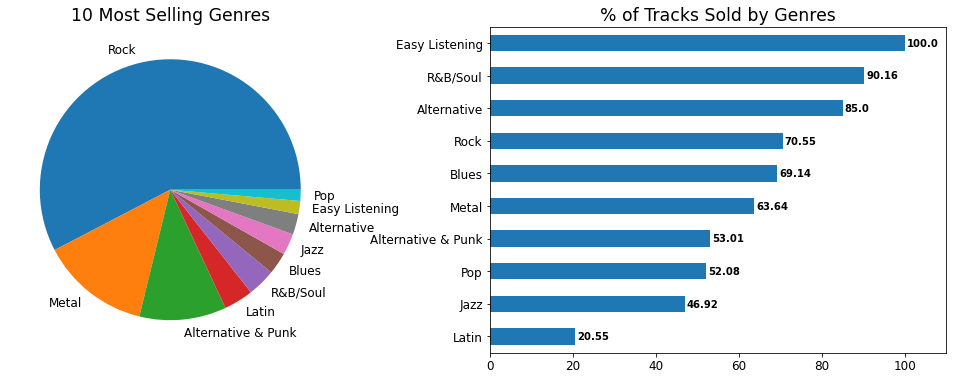

In [28]:
fig = plt.figure(figsize = (18,6))

genre_top_10 = genre_sales_df[:10]

ax1 = fig.add_subplot(1,2,1)
genre_top_10.plot( ax = ax1, kind="pie", y="Genre_Sales%",
                   legend=False, radius = 1, label="",
                   startangle=0, fontsize="large")
ax1.set_title(label="10 Most Selling Genres", fontsize="xx-large")

ax2 = fig.add_subplot(1,2,2)
genre_top_10 = genre_top_10.sort_values("Tracks_Sold%")
genre_top_10.plot( ax = ax2, kind="barh", y="Tracks_Sold%",
                    width=0.5, rot = 0, fontsize="large", legend=False, xlim=(0, 110))
ax2.set_title(label="% of Tracks Sold by Genres", fontsize="xx-large")
ax2.set_ylabel("")

for i, v in enumerate(genre_top_10["Tracks_Sold%"]):
    ax2.text(v + 0.5, i - 0.1, str(v), fontweight='bold')
              
plt.show()

<b>Conclusion: </b><i>It has already been established that 48% of tracks have not been purchased from Chinook (Add Ex1 above). That means there are several genres which have never been sold by the store.

Among the top selling genres following three show the maximum sales:</i>
    - Rock
    - Metal
    - Alternative & Punk
    
<i>However, the total tracks offered by each genre and the proportion of tracks actually sold does not parallel the Sales Distribution by Genre:</i>
    - Although with maximum sales, Rock genre has only 70% of tracks sold.
    - Metal genre is placed at 6th, with only 64% of tracks sold.
    - Only half of the tracks from Alternative & Punk genre have made it on customer's purchase list.
    - The genre, Easy Listening with only 1% of Total Sales, has sold all its tracks at Chinook.
    
It can be concluded, that the highest selling genres may still not be able to sell all the tracks listed under them.

<h3>Do protected vs non-protected media types have an effect on popularity?</h3>

This analysis accounts for:
    - The total tracks classified as Protected and Non-Protected files.
    - Actual percentage of tracks sold for each classification of files.

In [29]:
q = """
SELECT * FROM media_type
"""
run_query(q)

,media_type_id,name
0,1,MPEG audio file
1,2,Protected AAC audio file
2,3,Protected MPEG-4 video file
3,4,Purchased AAC audio file
4,5,AAC audio file


In [30]:
q = """
WITH
    track_media AS
    (
        SELECT
            COUNT(track_id) Total_Tracks,
            CASE
                WHEN M.name LIKE "Protected%" THEN "Protected"
                ELSE "Non-Protected"
            END AS Media
        FROM track T
        LEFT JOIN media_type M ON T.media_type_id = M.media_type_id
        GROUP BY 2
    ),
    track_sold AS
    (
        SELECT
            COUNT(DISTINCT(IL.track_id)) Tracks_Sold,
            CASE
                WHEN M.name LIKE "Protected%" THEN "Protected"
                ELSE "Non-Protected"
            END AS Media
        FROM invoice_line IL
        LEFT JOIN track T ON IL.track_id = T.track_id
        LEFT JOIN genre G ON T.genre_id = G.genre_id
        LEFT JOIN media_type M ON T.media_type_id = M.media_type_id
        GROUP BY 2
    )
    
SELECT
    Total_Tracks,
    Tracks_Sold,
    ROUND(Tracks_Sold/CAST(Total_Tracks AS FLOAT) *100, 2) "Tracks_Sold%",
    TM.Media
FROM track_media TM, track_sold TS
WHERE TM.Media = TS.Media
"""
run_query(q)

,Total_Tracks,Tracks_Sold,Tracks_Sold%,Media
0,3052,1652,54.13,Non-Protected
1,451,154,34.15,Protected


<b>Conclusion: </b><i>As established only 51% of all tracks have made sales at Chinook.

Since out of 451 available tracks classified as protected, 35% of tracks have been sold, it can't be decisively concluded that the media type affects the sales. It may be the track itself which affects the sales.